In [1]:
%load_ext autoreload
%autoreload 2
import sys
sys.path.append("../src")
import model.sdes as sdes
import model.discrete_diffusers as discrete_diffusers
import model.branch_definer as branch_definer
from plot.plot import plot_mnist_digits
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import tqdm.notebook

In [2]:
# Define device
if torch.cuda.is_available():
    DEVICE = "cuda"
else:
    DEVICE = "cpu"

### Create the data loader

In [3]:
samples_per_digit = 100
dataset = torchvision.datasets.MNIST(
    "/gstore/data/resbioai/tsenga5/datasets", train=True, transform=(lambda img: (np.asarray(img)[None] / 256 * 2) - 1)
)

classes = torch.unique(dataset.targets).cpu().numpy()
digits_by_class = {}
for c in classes:
    mask = dataset.targets == c
    digits = (dataset.data[mask] / 256 * 2) - 1
    sample_inds = torch.tensor(np.random.choice(len(digits), size=samples_per_digit, replace=False))
    digits_by_class[c] = digits[sample_inds][:, None].to(DEVICE)
input_shape = (1, 28, 28)

In [4]:
# Create the diffusers
diffuser = sdes.VariancePreservingSDE(0.1, 20, input_shape)
t_limit = 1

### Plotting functions

In [5]:
def plot_forward_diffusion(diffused_digits_by_class, times):
    """
    Plots example digits and the trajectory of the forward diffusion
    process.
    Arguments:
        `diffused_digits_by_class`: the output of
            `branch_definer.run_forward_diffusion`
        `times`: array of times that diffusion was performed at
    """
    # Plot some results over time
    inds_to_show = np.arange(0, len(times), len(times) // 15)
    inds_to_show = np.concatenate([inds_to_show, [len(times) - 1]])
    num_classes = len(diffused_digits_by_class)
    num_show_per_class = 3
    example_value = next(iter(diffused_digits_by_class.values()))
    batch_size, input_shape = example_value.shape[1], example_value.shape[2:]
    for t_i in inds_to_show:
        t = times[t_i]
        digits_to_show = np.empty((num_classes * num_show_per_class,) + input_shape)
        
        for c_i, c in enumerate(sorted(diffused_digits_by_class.keys())):
            # Sample digits
            inds = np.random.choice(
                diffused_digits_by_class[c].shape[1], size=num_show_per_class, replace=False
            )
            digits_to_show[c_i * num_show_per_class : (c_i + 1) * num_show_per_class] = \
                diffused_digits_by_class[c][t_i][inds].cpu().numpy()

        # Reshape:
        digits_to_show = digits_to_show.reshape(
            (num_classes, num_show_per_class) + digits_to_show.shape[1:]
        )
        digits_to_show = np.swapaxes(digits_to_show, 0, 1).reshape((-1,) + digits_to_show.shape[2:])
            
        plot_mnist_digits(digits_to_show, grid_size=(num_classes, num_show_per_class), title=("t = %.2f" % t))

    # Show distribution over time
    fig, ax = plt.subplots(figsize=(20, 8))
    bins = np.linspace(-4, 4, 1000)
    cmap = plt.get_cmap("magma")
    for t_i in tqdm.notebook.trange(len(times)):
        all_vals = np.concatenate([
            np.random.choice(np.ravel(digits[t_i].cpu().numpy()), size=100, replace=False)
            for digits in diffused_digits_by_class.values()
        ])
        ax.hist(all_vals, bins=bins, histtype="step", color=cmap(t_i / len(times)), alpha=0.5, density=True)
    prior = diffuser.sample_prior(batch_size, torch.ones(batch_size).to(DEVICE) * times[-1]).cpu().numpy()
    ax.hist(np.ravel(prior), bins=bins, histtype="step", color="blue", linewidth=2, density=True, label="Sampled prior")
    ax.set_xlabel("x")
    ax.set_ylabel("p(x)")
    ax.set_title("Evolution of p(x) over forward SDE")
    ax.set_ylim((0, 3))
    plt.legend()
    plt.show()

In [6]:
def plot_similarities(sim_matrix, classes):
    """
    Plots the similarities between classes.
    Arguments:
        `sim_matrix`: a T x C x C similarity matrix between classes
            at various time points, output by
            `branch_definer.compute_time_similarities`
        `classes`: list of classes matching the order in `sim_matrix`
    """
    # Plot initial pairwise similarities
    labels = np.array(["%s-%s" % (classes[i], classes[j]) for i in range(len(classes)) for j in range(i + 1)])
    sims = np.array([sim_matrix[0, i, j] for i in range(len(classes)) for j in range(i + 1)])
    inds = np.flip(np.argsort(sims))
    labels, sims = labels[inds], sims[inds]
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.bar(labels, sims)
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity between pairs of classes (t = 0)")
    plt.show()
                
    # Plot average similarity over time
    mean_sims = []
    triu_inds = np.triu_indices(len(classes))
    for t_i in range(len(sim_matrix)):
        mean_sims.append(np.mean(sim_matrix[t_i][triu_inds]))
    fig, ax = plt.subplots(figsize=(20, 4))
    ax.plot(mean_sims)
    ax.set_xlabel("t")
    ax.set_ylabel("Average similarity")
    ax.set_title("Average similarity over all classes during forward diffusion")
    plt.show()

In [14]:
def compute_time_similarities(diffused_inputs_by_class, times, verbose=True):
    """
    Given the output of `run_forward_diffusion`, computes the average
    similarity between classes at each time point.
    Arguments:
        `diffused_inputs_by_class`: dictionary mapping class to T x B x D
            tensors
        `times`: T-array of times at which diffusion was performed
        `verbose`: whether or not to print out progress updates
    Returns a T x C x C array of similarities between classes at each time, and
    a list of C classes parallel to the ordering in the similarity matrix.
    """
    classes = list(sorted(diffused_inputs_by_class.keys()))
    sim_matrix = np.empty((len(times), len(classes), len(classes), 100))

    t_iter = tqdm.trange(len(times)) if verbose else range(len(times))
    warning = True
    for t_i in t_iter:
        for i in range(len(classes)):
            for j in range(i + 1):
                inputs_1 = torch.flatten(
                    diffused_inputs_by_class[classes[i]][t_i].to(DEVICE),
                    start_dim=1
                )
                inputs_2 = torch.flatten(
                    diffused_inputs_by_class[classes[j]][t_i].to(DEVICE),
                    start_dim=1
                )

                if i == j:
                    # Flip so we always compare different objects
                    inputs_2 = torch.flip(inputs_2, dims=(0,))
                    if len(inputs_2) % 2 == 1:
                        mid = len(inputs_2) // 2
                        temp = inputs_2[mid]
                        inputs_2[mid] = inputs_2[0]
                        inputs_2[0] = temp
                elif inputs_1.shape[0] != inputs_2.shape[0]:
                    # Truncate to the same size
                    if inputs_1.shape[0] < inputs_2.shape[0]:
                        if warning:
                            print("Warning: truncating %d to %d samples" % (
                                inputs_2.shape[0], inputs_1.shape[0]
                            ))
                            warning = False
                        inputs_2 = inputs_2[:inputs_1.shape[0]]
                    else:
                        if warning:
                            print("Warning: truncating %d to %d samples" % (
                                inputs_1.shape[0], inputs_2.shape[0]
                            ))
                            warning = False
                        inputs_1 = inputs_1[:inputs_2.shape[0]]

                sims = torch.nn.functional.cosine_similarity(
                    inputs_1, inputs_2, dim=1
                ).detach().cpu().numpy()
                sim_matrix[t_i, i, j] = sims
                sim_matrix[t_i, j, i] = sims

    return sim_matrix, classes

### Compute branch definitions

In [12]:
# times = np.linspace(0, t_limit, 1000)
# diffused_digits_by_class = branch_definer.run_forward_diffusion(
#     digits_by_class, diffuser, times
# )
# plot_forward_diffusion(diffused_digits_by_class, times)
sim_matrix, sim_matrix_classes = compute_time_similarities(diffused_digits_by_class, times)
plot_similarities(sim_matrix, sim_matrix_classes)
branch_points = branch_definer.compute_branch_points(sim_matrix, times, sim_matrix_classes, epsilon=0.005)
branch_defs = branch_definer.branch_points_to_branch_defs(branch_points, t_limit)
print(branch_points)
print()
print(branch_defs)

  0%|▌                                                                                                                       | 5/1000 [00:00<00:24, 40.35it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  2%|█▊                                                                                                                     | 15/1000 [00:00<00:24, 40.32it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  2%|██▍                                                                                                                    | 20/1000 [00:00<00:24, 40.31it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  3%|███▌                                                                                                                   | 30/1000 [00:00<00:24, 40.28it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  4%|████▊                                                                                                                  | 40/1000 [00:00<00:23, 40.44it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  4%|█████▎                                                                                                                 | 45/1000 [00:01<00:23, 40.51it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  6%|██████▌                                                                                                                | 55/1000 [00:01<00:23, 40.58it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  6%|███████▋                                                                                                               | 65/1000 [00:01<00:22, 40.66it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  7%|████████▎                                                                                                              | 70/1000 [00:01<00:22, 40.80it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  8%|█████████▌                                                                                                             | 80/1000 [00:01<00:22, 40.87it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

  9%|██████████▋                                                                                                            | 90/1000 [00:02<00:22, 41.06it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 10%|███████████▎                                                                                                           | 95/1000 [00:02<00:22, 41.09it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 10%|████████████▍                                                                                                         | 105/1000 [00:02<00:21, 41.16it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 12%|█████████████▌                                                                                                        | 115/1000 [00:02<00:21, 41.18it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 12%|██████████████▏                                                                                                       | 120/1000 [00:02<00:21, 40.98it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 13%|███████████████▎                                                                                                      | 130/1000 [00:03<00:21, 40.74it/s]

torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size

 13%|███████████████▍                                                                                                      | 131/1000 [00:03<00:21, 40.49it/s]


torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])
torch.Size([100])


KeyboardInterrupt: 

In [15]:
sim_matrix, sim_matrix_classes = compute_time_similarities(diffused_digits_by_class, times)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:19<00:00, 51.83it/s]


In [29]:
points = [(np.where(times == p[0])[0][0], p[1], p[2]) for p in branch_points]
points

[(262, (4,), (9,)),
 (333, (4, 9), (7,)),
 (384, (5,), (8,)),
 (386, (3,), (5, 8)),
 (413, (3, 5, 8), (4, 7, 9)),
 (425, (3, 4, 5, 7, 8, 9), (2,)),
 (428, (2, 3, 4, 5, 7, 8, 9), (0,)),
 (432, (6,), (0, 2, 3, 4, 5, 7, 8, 9)),
 (469, (0, 2, 3, 4, 5, 6, 7, 8, 9), (1,))]

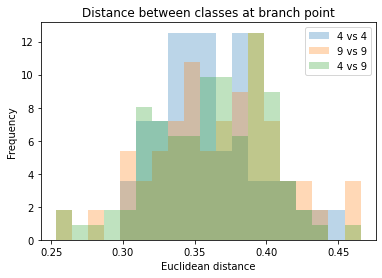

In [40]:
fig, ax = plt.subplots()
same_1 = sim_matrix[262, 4, 4]
same_2 = sim_matrix[262, 9, 9]
diff = sim_matrix[262, 4, 9]
total = np.concatenate([same_1, same_2, diff])
bins = np.linspace(np.min(total), np.max(total), 20)
ax.hist(same_1, bins=bins, density=True, alpha=0.3, label="4 vs 4")
ax.hist(same_2, bins=bins, density=True, alpha=0.3, label="9 vs 9")
ax.hist(diff, bins=bins, density=True, alpha=0.3, label="4 vs 9")
ax.legend()
ax.set_title("Distance between classes at branch point")
ax.set_xlabel("Euclidean distance")
ax.set_ylabel("Frequency")
fig.savefig("/gstore/home/tsenga5/temp/branch_point_dists.svg", format="svg")
plt.show()